# Energy Injection in 1D Brown Dwarf Climate Models

In this tutorial you will learn how you can add in an arbitrary amount of energy into your climate model. This could be because you want to build an intuition on the impact of temperature inversions or see if there are hot spots in your object causing variability in the observations for example. 

You should be comfortable with running climate models by now, the minimum requirement for this tutorial is [One-Dimensional Climate Models: The Basics of Brown Dwarfs](https://natashabatalha.github.io/picaso/notebooks/climate/12a_BrownDwarf.html).

In [1]:
import sys
import os

sys.path.append("/Users/jjm6243/Documents/picaso/")
sys.path.append("/Users/jjm6243/Documents/virga/")
os.environ['picaso_refdata'] = "/Users/jjm6243/Documents/picaso/reference/"
os.environ['PYSYN_CDBS'] = "/Users/jjm6243/Documents/picaso/grp/hst/cdbs/"

import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import virga.justdoit as vj
import virga.justplotit as cldplt
jpi.output_notebook()
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray
from bokeh.plotting import show, figure
import pandas as pd

Loading BokehJS ...

## Analytical Energy Injection

In this part of the tutorial we are going to be comparing our climate models with those from [Morley et al. 2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...789L..14M/abstract). We are going to test the case for a 600 K brown dwarf. To inject the energy into the atmosphere we are going to use the Chapman function to describe the profile of the energy deposition. The Chapman function is selected because it is often used
to represent heating by incident flux within molecular bands.

We are going to initiate our profile just like any other basic climate model first

In [2]:
# #1 ck tables from roxana
# mh = '+000'#'+0.0' #log metallicity
# CtoO = '100'#'1.0' # CtoO ratio

# ck_db = f'/data/kcoeff_2020_v3/sonora_2020_feh{mh}_co_{CtoO}.data.196'
# #sonora bobcat cloud free structures file
# sonora_profile_db = '/data/sonora_bobcat/structure/structures_m+0.0'




#1 ck tables from roxana
mh = '+000'#'+0.0' #log metallicity
CtoO = '100'#'1.0' # CtoO ratio

# ck_db = f'/home/jjm6243/egp_ty/run/freedman/sonora_2020_feh{mh}_co_{CtoO}.data.196'
ck_db = f"/Users/jjm6243/Documents/freedman/sonora_2020_feh{mh}_co_{CtoO}.data.196"
sonora_profile_db = '/Users/jjm6243/Documents/sonora_profile/'
sonora_dat_db = '/Users/jjm6243/Documents/bobcat_structures/structures_m+0.0/'

In [3]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation

#note you need to put the climate keyword to be True in order to do so
# now you need to add these parameters to your calculation

teff= 600 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(teff) # input effective temperature

opacity_ck = jdi.opannection(ck_db=ck_db) # grab your opacities

In [4]:
nlevel = 91 # number of plane-parallel levels in your code

pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.cmp.gz"),
                            usecols=[1,2],unpack=True, skiprows = 1)

In [5]:
nofczns = 1 # number of convective zones initially

nstr_upper = 87 # top most level of guessed convective zone 

nstr_deep = nlevel - 2 # this is always the case. Dont change this

nstr = np.array([0,nstr_upper,nstr_deep,0,0,0])

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

**New PICASO code parameters**: 

1. `inject_energy` : (True/False) Turns on energy injection. Default = False
2. `total_energy_injection` : (float) Desired total amount of energy to be deposited in units of ergs/cm^2/s
3. `press_max_energy` : (float) Pressure for maximum energy injection in units of bars for chapman function
4. `injection_scaleheight` :  (float) Scalar specifying the number of scale heights over which energy is deposited

In [6]:
cl_run.inputs_climate(temp_guess= temp_bobcat, pressure= pressure_bobcat,
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv, inject_energy = True, total_energy_injection= 3.67e6,
                      press_max_energy = 1, injection_scalehight= 1)

In [7]:
out = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True)

Iteration number  0 , min , max temp  181.70671255589204 2265.5137157694667 , flux balance  2.7982798581114814
Iteration number  1 , min , max temp  273.5209463553998 2469.2263050322695 , flux balance  0.314362725736158
Iteration number  2 , min , max temp  247.25978535463045 2442.0294295913704 , flux balance  0.001531332476920761
Iteration number  3 , min , max temp  240.07543735934632 2441.4005661267383 , flux balance  3.397237177323955e-07
Iteration number  4 , min , max temp  239.38028573055752 2441.398742256938 , flux balance  2.2763186942827453e-11
In t_start: Converged Solution in iterations  4
Big iteration is  239.38028573055752 0
Iteration number  0 , min , max temp  241.5848432635902 2508.798735313967 , flux balance  0.10287486522207762
Iteration number  1 , min , max temp  245.47342202550513 2613.397330154188 , flux balance  0.00016885774629053432
Iteration number  2 , min , max temp  245.5040017080572 2607.0550740724675 , flux balance  6.786116031492476e-09
In t_start: Con

In [8]:
# Now let's read in our benchmark profile from Morley et. al 2014
benchmark = pd.read_csv('t600g1000nc-3.67e6-h1-1bar.dat',skiprows=1, delim_whitespace=True)

#we only want to compare the P-T profile so we don't care about the other columns
benchmark.columns = ['level', 'pressure', 'temperature', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']

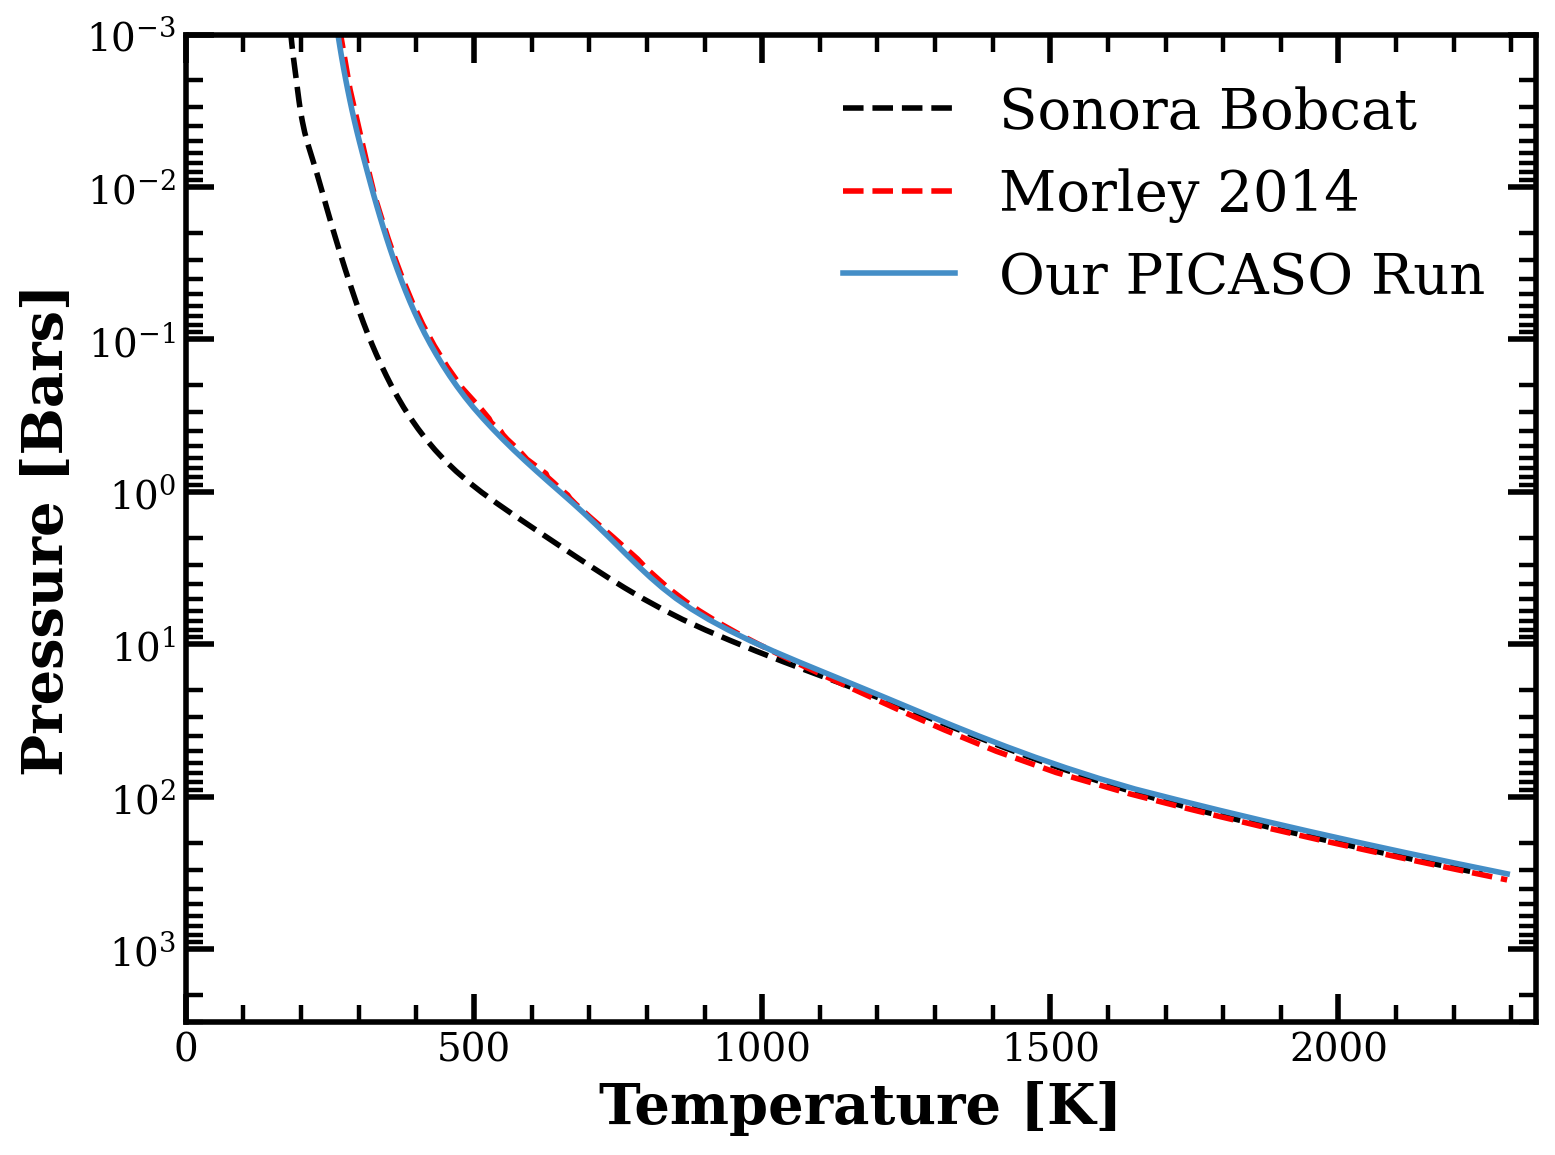

In [9]:
pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.cmp.gz"),
                            usecols=[1,2],unpack=True, skiprows = 1)
plt.figure(figsize=(8,6))
plt.ylabel("Pressure [Bars]")
plt.xlabel('Temperature [K]')
plt.xlim(0,max(out['temperature'])+50)
plt.ylim(3e3,1e-3)

plt.semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",label="Sonora Bobcat")
plt.semilogy(benchmark['temperature'],benchmark['pressure'],color="r",linestyle="--",label="Morley 2014")
plt.semilogy(out['temperature'],out['pressure'],label="Our PICASO Run")

plt.legend()
plt.tight_layout()
plt.show()

When you generate these models, remember that because you artificially injected energy into the atmosphere, the profile will be **warmer** than the desired effective temperature that you set for the object!

## Numerical Energy Injection

Let's say you don't want to use something like the Chapman function because you have an actual profile of energy deposition you'd like to include in your model. We can add a couple of other inputs to do this.

In [10]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation

#note you need to put the climate keyword to be True in order to do so
# now you need to add these parameters to your calculation

teff= 600 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(teff) # input effective temperature

opacity_ck = jdi.opannection(ck_db=ck_db) # grab your opacities

In [11]:
nlevel = 91 # number of plane-parallel levels in your code

pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.cmp.gz"),
                            usecols=[1,2],unpack=True, skiprows = 1)

In [12]:
nofczns = 1 # number of convective zones initially

nstr_upper = 87 # top most level of guessed convective zone 

nstr_deep = nlevel - 2 # this is always the case. Dont change this

nstr = np.array([0,nstr_upper,nstr_deep,0,0,0])

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

Here we're going to generate a Gaussian distribution of energy that will be injected into the upper atmosphere of this climate model just as an example how you can use any energy profile you'd like

In [13]:
from scipy.stats import norm

# Define the center and width of the Gaussian
center = 45  # Index for the peak of the Gaussian
width = 10    # Standard deviation of the Gaussian

# Create a Gaussian profile
beam_profile = norm.pdf(np.arange(len(pressure_bobcat)), loc=center, scale=width)

# Normalize the Gaussian to match the desired energy range
beam_profile = beam_profile / beam_profile.max() * 6e5  # Scale to the desired range

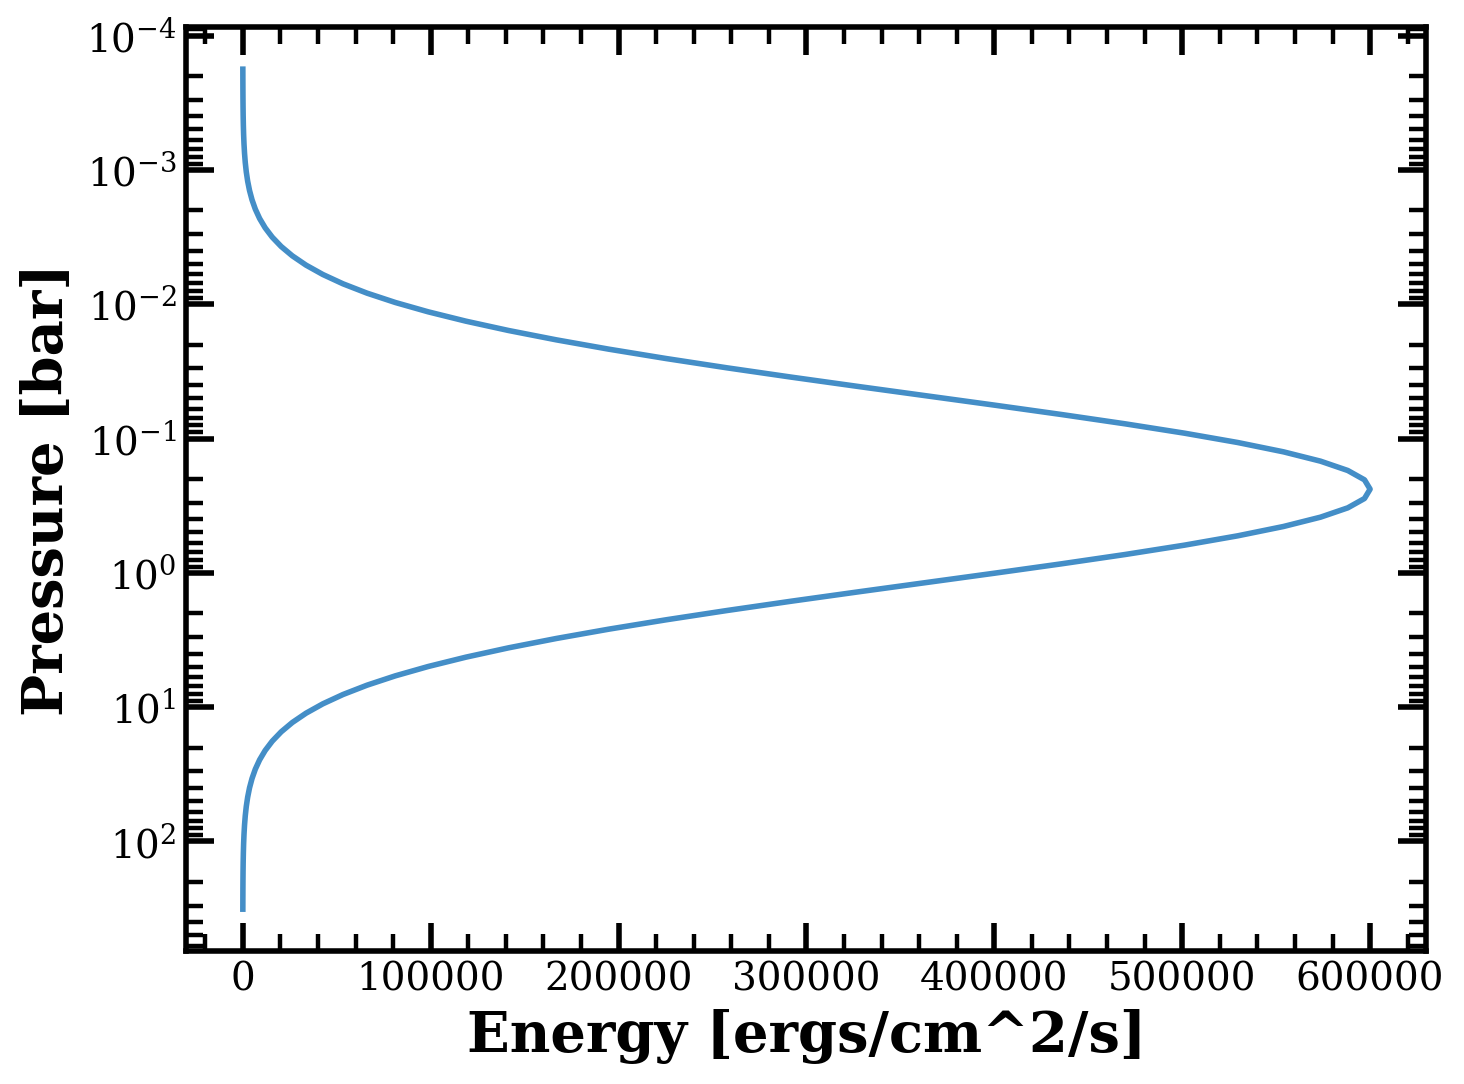

In [ ]:
plt.semilogy(beam_profile, pressure_bobcat, label='Gaussian Energy Beam Profile')
plt.gca().invert_yaxis()
plt.xlabel('Energy [ergs/cm^2/s]')
plt.ylabel('Pressure [Bars]')
plt.show()

**New PICASO code parameters**: 

1. `inject_energy` : (bool) Turns on energy injection. Default = False
2. `inject_beam` : (bool) Turns on using your own energy profile instead of the Chapman function
3. `beam_profile` : (array) Array of the energy profile. The shape of this array needs to be the same as the pressure grid.

In [15]:
cl_run.inputs_climate(temp_guess= temp_bobcat, pressure= pressure_bobcat,
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv, inject_energy = True, inject_beam = True, beam_profile = beam_profile)

In [16]:
out = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True)

Iteration number  0 , min , max temp  185.58888837765906 2249.5519454372784 , flux balance  9.160883508853926
Iteration number  1 , min , max temp  487.45195550741755 2272.286292292116 , flux balance  4.829649649365461
Iteration number  2 , min , max temp  630.019925387412 2340.2415064143597 , flux balance  1.3872835614719412
Iteration number  3 , min , max temp  729.5360441467442 2450.1078825352893 , flux balance  0.07965654219915257
Iteration number  4 , min , max temp  713.5201673473773 2441.797687495971 , flux balance  0.00018615133179221313
Iteration number  5 , min , max temp  669.711808063819 2441.725398070999 , flux balance  3.2360116194740443e-07
Iteration number  6 , min , max temp  662.213461366226 2441.725221303934 , flux balance  6.462740895261918e-11
 We are already at a root, tolf , test =  5e-05 ,  3.3082424742438435e-06
Big iteration is  662.213461366226 0
Iteration number  0 , min , max temp  653.6320832015298 2477.31608487946 , flux balance  0.10643394670960053
Itera

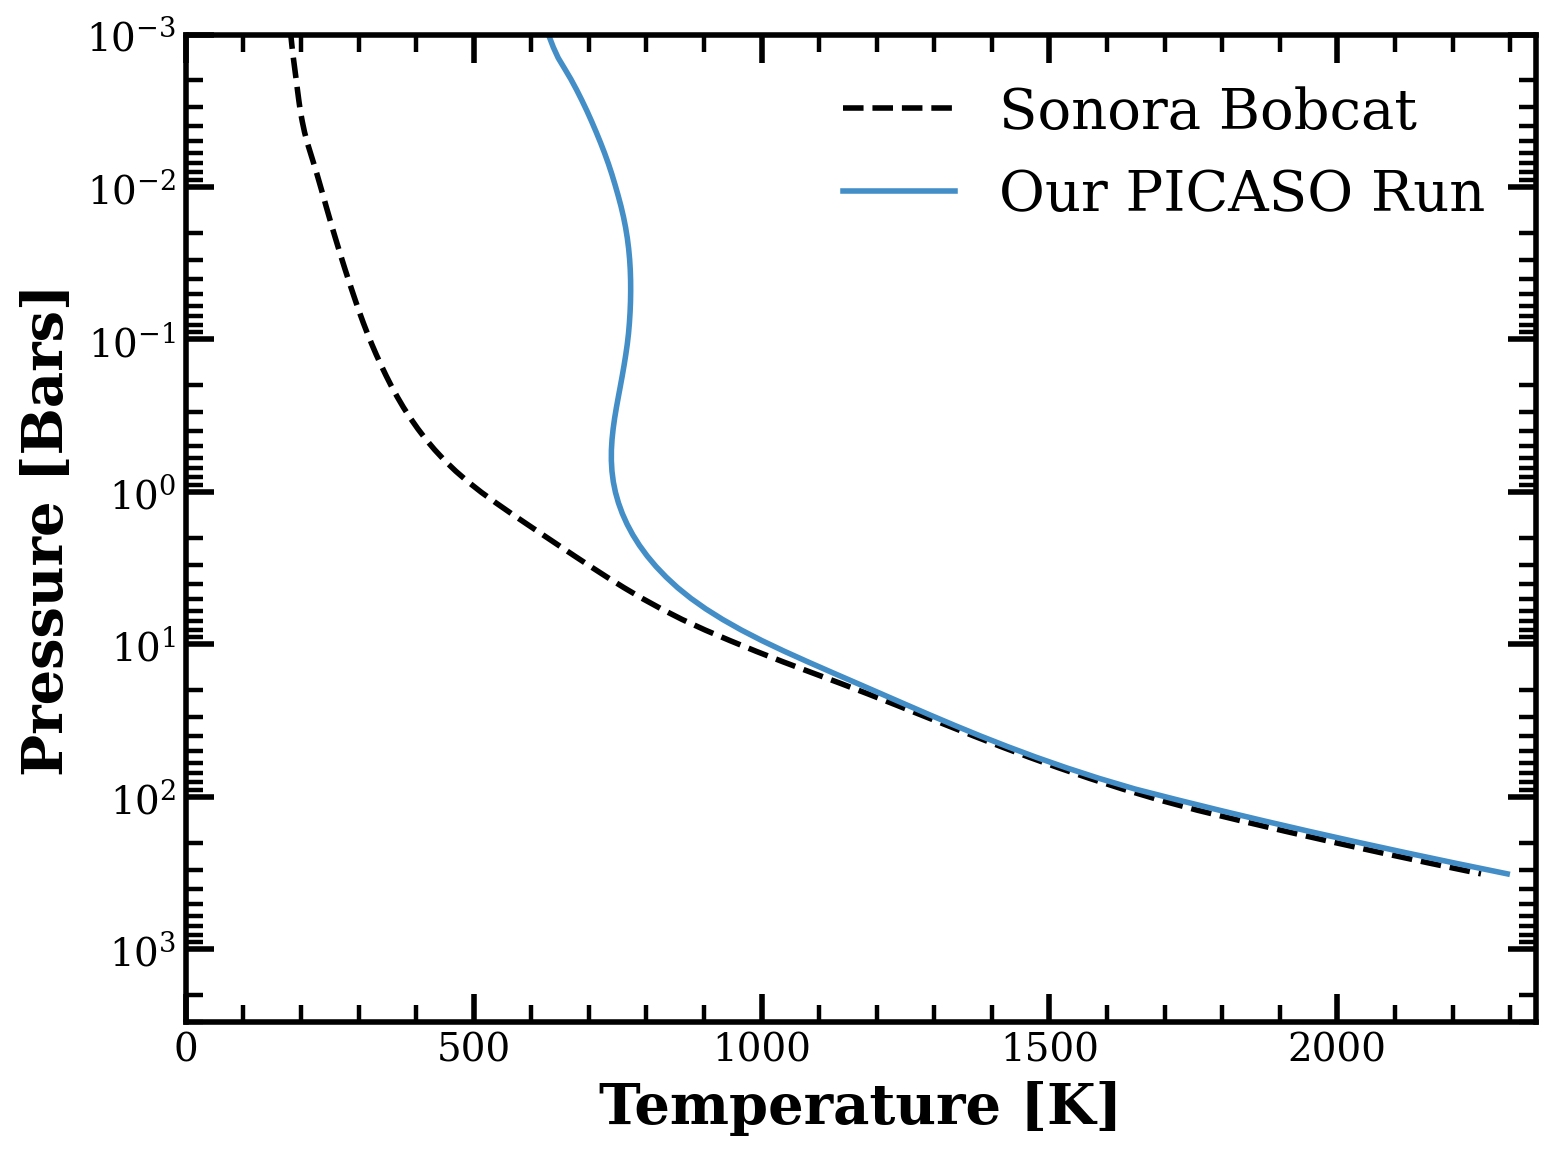

In [17]:
pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.cmp.gz"),
                            usecols=[1,2],unpack=True, skiprows = 1)
plt.figure(figsize=(8,6))
plt.ylabel("Pressure [Bars]")
plt.xlabel('Temperature [K]')
plt.xlim(0,max(out['temperature'])+50)
plt.ylim(3e3,1e-3)

plt.semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",label="Sonora Bobcat")
plt.semilogy(out['temperature'],out['pressure'],label="Our PICASO Run")

plt.legend()
plt.tight_layout()
plt.show()